In [3]:
from sklearn.datasets import load_breast_cancer, fetch_california_housing, load_iris
import pandas as pd

cancer = load_breast_cancer()
cancer_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
cancer_df['target'] = cancer.target
cancer_df.to_csv('breast_cancer.csv', index=False)

housing = fetch_california_housing()
housing_df = pd.DataFrame(housing.data, columns=housing.feature_names)
housing_df['target'] = housing.target
housing_df.to_csv('california_housing.csv', index=False)

iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['target'] = iris.target
iris_df.to_csv('iris.csv', index=False)

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def calculate_correlation_matrix(dataset_name, df, target_col='target'):    
    features = df.drop(columns=[target_col], errors='ignore')
    
    correlation_matrix = features.corr()
    
    plt.figure(figsize=(15, 12))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True, 
                fmt=".2f", 
                cmap='coolwarm', 
                center=0,
                square=True,
                cbar_kws={"shrink": .8})
    plt.title(f'Corr Matrix of - {dataset_name}\n', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'correlation_heatmap_{dataset_name.replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return correlation_matrix, features

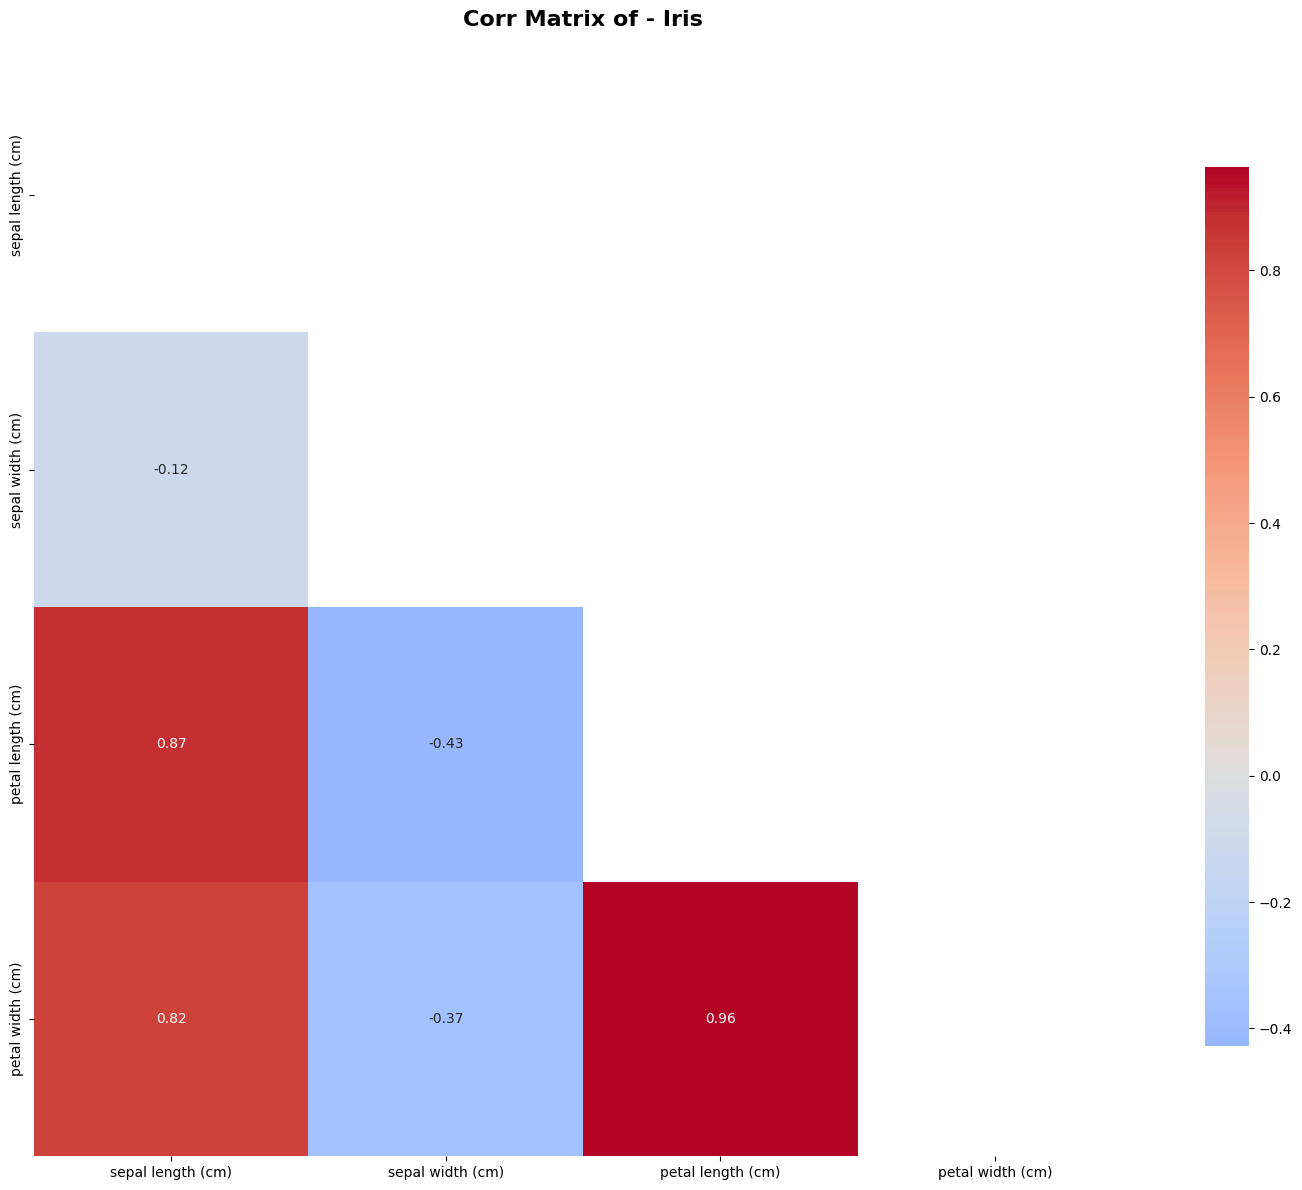

(                   sepal length (cm)  sepal width (cm)  petal length (cm)  \
 sepal length (cm)           1.000000         -0.117570           0.871754   
 sepal width (cm)           -0.117570          1.000000          -0.428440   
 petal length (cm)           0.871754         -0.428440           1.000000   
 petal width (cm)            0.817941         -0.366126           0.962865   
 
                    petal width (cm)  
 sepal length (cm)          0.817941  
 sepal width (cm)          -0.366126  
 petal length (cm)          0.962865  
 petal width (cm)           1.000000  ,
      sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
 0                  5.1               3.5                1.4               0.2
 1                  4.9               3.0                1.4               0.2
 2                  4.7               3.2                1.3               0.2
 3                  4.6               3.1                1.5               0.2
 4               

In [8]:
# calculate_correlation_matrix("Cancer", cancer_df)
# calculate_correlation_matrix("Housing", housing_df)
calculate_correlation_matrix("Iris", iris_df)

In [9]:
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler

def apply_pca(X, variance_threshold=0.95):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    pca = PCA()
    pca.fit(X_scaled)
    
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(cumulative_variance >= variance_threshold) + 1
    
    pca_final = PCA(n_components=n_components)
    X_pca = pca_final.fit_transform(X_scaled)
    
    return X_pca, n_components, cumulative_variance

def apply_ica(X, n_components=None):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    if n_components is None:
        n_components = X.shape[1]
    
    ica = FastICA(n_components=n_components, random_state=42)
    X_ica = ica.fit_transform(X_scaled)
    
    return X_ica

def apply_svd(X, n_components=None):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    if n_components is None:
        n_components = min(X_scaled.shape)
    
    U, s, Vt = np.linalg.svd(X_scaled, full_matrices=False)
    
    explained_variance = (s ** 2) / np.sum(s ** 2)
    cumulative_variance = np.cumsum(explained_variance)
    
    X_svd = U[:, :n_components] * s[:n_components]
    
    return X_svd, n_components, cumulative_variance


cancer_df_drop_tar = cancer_df.drop('target', axis=1)
cancer_df__pca, n_pca, var_pca = apply_pca(cancer_df_drop_tar)
cancer_df__ica = apply_ica(cancer_df_drop_tar, n_components=n_pca)
cancer_df__svd, n_svd, var_svd = apply_svd(cancer_df_drop_tar, n_components=n_pca)

housing_df_drop_tar = housing_df.drop('target', axis=1)
housing_df__pca, n_pca, var_pca = apply_pca(housing_df_drop_tar)
housing_df__ica = apply_ica(housing_df_drop_tar, n_components=n_pca)
housing_df__svd, n_svd, var_svd = apply_svd(housing_df_drop_tar, n_components=n_pca)

iris_df_drop_tar = iris_df.drop('target', axis=1)
iris_df__pca, n_pca, var_pca = apply_pca(iris_df_drop_tar)
iris_df__ica = apply_ica(iris_df_drop_tar, n_components=n_pca)
iris_df__svd, n_svd, var_svd = apply_svd(iris_df_drop_tar, n_components=n_pca)

In [11]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_score

def compare_methods(X_original, y, X_pca, X_ica, X_svd):
    scores = {}
    
    if len(np.unique(y)) <= 10:
        model = RandomForestClassifier(random_state=42)
        scoring = 'accuracy'
    else:
        model = RandomForestRegressor(random_state=42)
        scoring = 'r2'
    
    scores['Original'] = cross_val_score(model, X_original, y, cv=5, scoring=scoring).mean()
    scores['PCA'] = cross_val_score(model, X_pca, y, cv=5, scoring=scoring).mean()
    scores['ICA'] = cross_val_score(model, X_ica, y, cv=5, scoring=scoring).mean()
    scores['SVD'] = cross_val_score(model, X_svd, y, cv=5, scoring=scoring).mean()
    
    best_method = max(scores, key=scores.get)
    return best_method, scores

best_cancer, scores_cancer = compare_methods(
    cancer_df_drop_tar, cancer_df['target'], 
    cancer_df__pca, cancer_df__ica, cancer_df__svd
)

best_housing, scores_housing = compare_methods(
    housing_df_drop_tar, housing_df['target'],
    housing_df__pca, housing_df__ica, housing_df__svd
)

best_iris, scores_iris = compare_methods(
    iris_df_drop_tar, iris_df['target'],
    iris_df__pca, iris_df__ica, iris_df__svd
)

print(f"Breast Cancer - Best: {best_cancer}, Scores: {scores_cancer}")
print(f"California Housing - Best: {best_housing}, Scores: {scores_housing}")
print(f"Iris - Best: {best_iris}, Scores: {scores_iris}")

Breast Cancer - Best: Original, Scores: {'Original': np.float64(0.9560937742586555), 'PCA': np.float64(0.947259742276044), 'ICA': np.float64(0.9261605340785592), 'SVD': np.float64(0.9525073746312683)}
California Housing - Best: Original, Scores: {'Original': np.float64(0.6561187027256853), 'PCA': np.float64(0.5268604365953843), 'ICA': np.float64(0.5344552849363475), 'SVD': np.float64(0.5270556613883361)}
Iris - Best: Original, Scores: {'Original': np.float64(0.9666666666666668), 'PCA': np.float64(0.9066666666666666), 'ICA': np.float64(0.8933333333333333), 'SVD': np.float64(0.9066666666666666)}


In [23]:
from sklearn.feature_selection import SelectKBest, f_classif, f_regression, RFE
from sklearn.linear_model import LogisticRegression, LinearRegression

def apply_feature_selection(X, y, k=None):
    if k is None:
        k = X.shape[1] // 2
    
    if len(np.unique(y)) <= 10:
        selector_kbest = SelectKBest(score_func=f_classif, k=k)
        model_rfe = LogisticRegression(random_state=42, max_iter=1000)
    else:
        selector_kbest = SelectKBest(score_func=f_regression, k=k)
        model_rfe = LinearRegression()
    
    X_kbest = selector_kbest.fit_transform(X, y)
    
    rfe_selector = RFE(estimator=model_rfe, n_features_to_select=k)
    X_rfe = rfe_selector.fit_transform(X, y)
    
    return X_kbest, X_rfe

cancer_kbest, cancer_rfe = apply_feature_selection(cancer_df_drop_tar, cancer_df['target'])
housing_kbest, housing_rfe = apply_feature_selection(housing_df_drop_tar, housing_df['target'])
iris_kbest, iris_rfe = apply_feature_selection(iris_df_drop_tar, iris_df['target'])

print(f"Breast Cancer: {cancer_df_drop_tar.shape[1]} -> KBest:{cancer_kbest.shape[1]}, RFE:{cancer_rfe.shape[1]}")
print(f"California Housing: {housing_df_drop_tar.shape[1]} -> KBest:{housing_kbest.shape[1]}, RFE:{housing_rfe.shape[1]}")
print(f"Iris: {iris_df_drop_tar.shape[1]} -> KBest:{iris_kbest.shape[1]}, RFE:{iris_rfe.shape[1]}")

C:\Users\Reza\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Reza\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Breast Cancer: 30 -> KBest:15, RFE:15
California Housing: 8 -> KBest:4, RFE:4
Iris: 4 -> KBest:2, RFE:2


In [24]:
def compare_fs_methods(X_original, y, X_kbest, X_rfe):
    if len(np.unique(y)) <= 10:
        model = RandomForestClassifier(random_state=42)
        scoring = 'accuracy'
    else:
        model = RandomForestRegressor(random_state=42)
        scoring = 'r2'
    
    original_score = cross_val_score(model, X_original, y, cv=5, scoring=scoring).mean()
    kbest_score = cross_val_score(model, X_kbest, y, cv=5, scoring=scoring).mean()
    rfe_score = cross_val_score(model, X_rfe, y, cv=5, scoring=scoring).mean()
    
    best_method = 'KBest' if kbest_score > rfe_score else 'RFE'
    best_score = max(kbest_score, rfe_score)
    
    return best_method, best_score, original_score, kbest_score, rfe_score

best_cancer, score_cancer, orig_cancer, kbest_cancer, rfe_cancer = compare_fs_methods(
    cancer_df_drop_tar, cancer_df['target'], cancer_kbest, cancer_rfe
)

best_housing, score_housing, orig_housing, kbest_housing, rfe_housing = compare_fs_methods(
    housing_df_drop_tar, housing_df['target'], housing_kbest, housing_rfe
)

best_iris, score_iris, orig_iris, kbest_iris, rfe_iris = compare_fs_methods(
    iris_df_drop_tar, iris_df['target'], iris_kbest, iris_rfe
)

print(f"Breast Cancer - Best: {best_cancer}, KBest: {kbest_cancer:.4f}, RFE: {rfe_cancer:.4f}, Original: {orig_cancer:.4f}")
print(f"California Housing - Best: {best_housing}, KBest: {kbest_housing:.4f}, RFE: {rfe_housing:.4f}, Original: {orig_housing:.4f}")
print(f"Iris - Best: {best_iris}, KBest: {kbest_iris:.4f}, RFE: {rfe_iris:.4f}, Original: {orig_iris:.4f}")

Breast Cancer - Best: RFE, KBest: 0.9438, RFE: 0.9578, Original: 0.9561
California Housing - Best: RFE, KBest: 0.3735, RFE: 0.5321, Original: 0.6561
Iris - Best: RFE, KBest: 0.9667, RFE: 0.9667, Original: 0.9667


In [25]:
# So we have these:
# cancer_df 
# cancer_rfe
# cancer_df__pca

# housing_df
# housing_rfe
# housing_df__pca

# iris_df
# iris_kbest
# iris_df__pca

In [29]:
def compare_regression_models(X_original, X_pca, X_fs, y):
    original_model = LinearRegression()
    pca_model = LinearRegression()
    fs_model = LinearRegression()

    original_coef = original_model.fit(X_original, y).coef_
    pca_coef = pca_model.fit(X_pca, y).coef_
    fs_coef = fs_model.fit(X_fs, y).coef_

    original_score = cross_val_score(LinearRegression(), X_original, y, cv=5, scoring='r2').mean()
    pca_score = cross_val_score(LinearRegression(), X_pca, y, cv=5, scoring='r2').mean()
    fs_score = cross_val_score(LinearRegression(), X_fs, y, cv=5, scoring='r2').mean()

    return {
        'original_coef': original_coef,
        'pca_coef': pca_coef,
        'fs_coef': fs_coef,
        'original_score': original_score,
        'pca_score': pca_score,
        'fs_score': fs_score,
        'coef_std_original': np.std(original_coef),
        'coef_std_pca': np.std(pca_coef),
        'coef_std_fs': np.std(fs_coef),
        'coef_range_original': np.ptp(original_coef),
        'coef_range_pca': np.ptp(pca_coef),
        'coef_range_fs': np.ptp(fs_coef)
    }

housing_results = compare_regression_models(
    housing_df_drop_tar,
    housing_df__pca,
    housing_kbest if best_housing == 'KBest' else housing_rfe,
    housing_df['target']
)

print("California Housing Results:")
print(f"R2 Scores - Original: {housing_results['original_score']:.4f}, PCA: {housing_results['pca_score']:.4f}, FS: {housing_results['fs_score']:.4f}")
print(f"Coefficient STD - Original: {housing_results['coef_std_original']:.4f}, PCA: {housing_results['coef_std_pca']:.4f}, FS: {housing_results['coef_std_fs']:.4f}")
print(f"Coefficient Range - Original: {housing_results['coef_range_original']:.4f}, PCA: {housing_results['coef_range_pca']:.4f}, FS: {housing_results['coef_range_fs']:.4f}")
print("\nOriginal Coefficients:", housing_results['original_coef'])
print("PCA Coefficients:", housing_results['pca_coef'])
print("FS Coefficients:", housing_results['fs_coef'])


California Housing Results:
R2 Scores - Original: 0.5530, PCA: 0.4316, FS: 0.5341
Coefficient STD - Original: 0.3505, PCA: 0.3331, FS: 0.3958
Coefficient Range - Original: 1.0796, PCA: 1.0615, FS: 0.8865

Original Coefficients: [ 4.36693293e-01  9.43577803e-03 -1.07322041e-01  6.45065694e-01
 -3.97638942e-06 -3.78654265e-03 -4.21314378e-01 -4.34513755e-01]
PCA Coefficients: [ 0.02815106  0.13630222  0.03983107 -0.74137041  0.0038712   0.32016506]
FS Coefficients: [ 0.36686091  0.16556978 -0.50511486 -0.5196499 ]


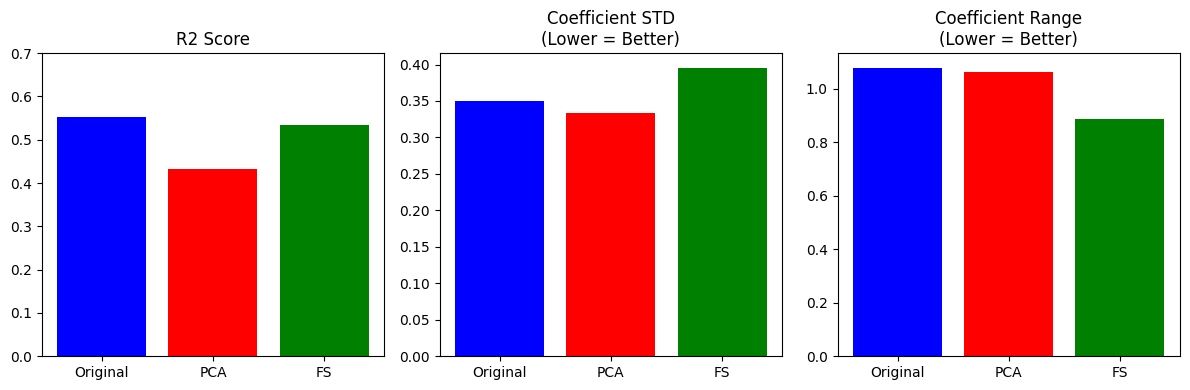

In [33]:
methods = ['Original', 'PCA', 'FS']
scores = [0.5530, 0.4316, 0.5341]
stds = [0.3505, 0.3331, 0.3958]
ranges = [1.0796, 1.0615, 0.8865]

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.bar(methods, scores, color=['blue', 'red', 'green'])
plt.title('R2 Score')
plt.ylim(0, 0.7)

plt.subplot(1, 3, 2)
plt.bar(methods, stds, color=['blue', 'red', 'green'])
plt.title('Coefficient STD\n(Lower = Better)')

plt.subplot(1, 3, 3)
plt.bar(methods, ranges, color=['blue', 'red', 'green'])
plt.title('Coefficient Range\n(Lower = Better)')

plt.tight_layout()
plt.savefig('regression_comparison.png')
plt.show()